In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
with open('ITSector2.json', 'r') as f:
    data = json.load(f)

companies = data["Companies"]


In [4]:
# Create a list to hold summary data for each company
rows = []
for comp_name, comp_data in companies.items():
    # Extract sections: Balance Sheet and Profit & Loss
    bs = comp_data.get("Balance_Sheet", {})
    pl = comp_data.get("Profit_Loss", {})
    
    # Extract the most recent values (last element) from the arrays.
    # Adjust the keys if needed.
    total_assets = bs.get("Total assets", [None])[-1]
    total_equity = bs.get("Total shareholders funds", [None])[-1]
    revenue = pl.get("Revenue from operations [gross]", [None])[-1]
    net_profit = pl.get("Net profit/(loss) for the period]", [None])[-1]
    
    # Compute total liabilities as total_assets minus total_equity (if both available)
    total_liabilities = total_assets - total_equity if total_assets is not None and total_equity is not None else None

    rows.append({
        "company": comp_name,
        "total_assets": total_assets,
        "total_equity": total_equity,
        "total_liabilities": total_liabilities,
        "revenue": revenue,
        "net_profit": net_profit
    })


In [5]:
# Create a DataFrame from the collected data
df = pd.DataFrame(rows)
print("Extracted Data:")
print(df)

Extracted Data:
                        company  total_assets  total_equity  \
0               3i Infotech Ltd        497.45         87.26   
1           Adroit Infotech Ltd         41.08         30.53   
2               Affle India Ltd       2027.20       1731.13   
3       AION-TECH SOLUTIONS Ltd         91.21         59.98   
4   Allied Digital Services Ltd        603.79        475.21   
..                          ...           ...           ...   
70            WEP Solutions Ltd         89.89         60.22   
71                    Wipro Ltd      81648.60      57781.90   
72      Xchanging Solutions Ltd        352.87        314.33   
73        Xtglobal Infotech Ltd        213.96        182.71   
74      Zensar Technologies Ltd       3138.80       2680.60   

    total_liabilities   revenue net_profit  
0              410.19    357.33       None  
1               10.55      5.87       None  
2              296.07    545.18       None  
3               31.23     79.01       None  
4 

In [6]:
# --- Step 2: Feature Engineering – Calculate Financial Ratios ---

df['profit_margin'] = df['net_profit'] / df['revenue']        # Profit Margin: Net Profit / Revenue
df['ROA'] = df['net_profit'] / df['total_assets']             # Return on Assets: Net Profit / Total Assets
df['ROE'] = df['net_profit'] / df['total_equity']              # Return on Equity: Net Profit / Total Equity
df['debt_to_equity'] = df['total_liabilities'] / df['total_equity']  # Debt-to-Equity Ratio


In [7]:
print("\nData with Calculated Ratios:")
print(df[['company', 'profit_margin', 'ROA', 'ROE', 'debt_to_equity']])


Data with Calculated Ratios:
                        company profit_margin  ROA  ROE  debt_to_equity
0               3i Infotech Ltd           NaN  NaN  NaN        4.700779
1           Adroit Infotech Ltd           NaN  NaN  NaN        0.345562
2               Affle India Ltd           NaN  NaN  NaN        0.171027
3       AION-TECH SOLUTIONS Ltd           NaN  NaN  NaN        0.520674
4   Allied Digital Services Ltd           NaN  NaN  NaN        0.270575
..                          ...           ...  ...  ...             ...
70            WEP Solutions Ltd           NaN  NaN  NaN        0.492693
71                    Wipro Ltd           NaN  NaN  NaN        0.413048
72      Xchanging Solutions Ltd           NaN  NaN  NaN        0.122610
73        Xtglobal Infotech Ltd           NaN  NaN  NaN        0.171036
74      Zensar Technologies Ltd           NaN  NaN  NaN        0.170932

[75 rows x 5 columns]


In [8]:
# Select features for correlation analysis
features = ['revenue', 'net_profit', 'total_assets', 'total_equity', 'total_liabilities',
            'profit_margin', 'ROA', 'ROE', 'debt_to_equity']
corr_matrix = df[features].corr()

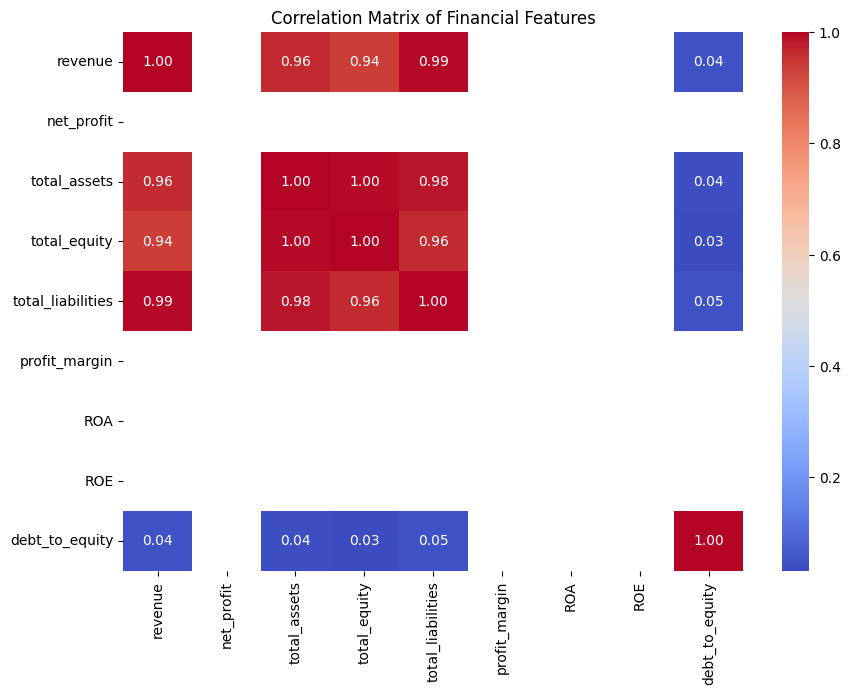

In [9]:
# Visualize the correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Financial Features")
plt.show()

In [10]:
# --- Step 4: Dimensionality Reduction with PCA ---

# Drop any rows with missing values in the selected features
data_for_pca = df[features].dropna()

In [14]:
from sklearn.impute import SimpleImputer

# 1. Select the same features
features = ['revenue', 'net_profit', 'total_assets', 'total_equity',
            'total_liabilities', 'profit_margin', 'ROA', 'ROE', 'debt_to_equity']

data_for_pca = df[features]

# 2. Impute missing values (fill with column mean)
imputer = SimpleImputer(strategy='mean')
data_for_pca_imputed = imputer.fit_transform(data_for_pca)

# 3. Standardize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_pca_imputed)

# 4. Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

print("PCA shape:", principal_components.shape)

PCA shape: (75, 2)


c:\Users\sharm\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['net_profit' 'profit_margin' 'ROA' 'ROE']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Explained variance ratio by PC1 and PC2: [0.78450528 0.19959718]


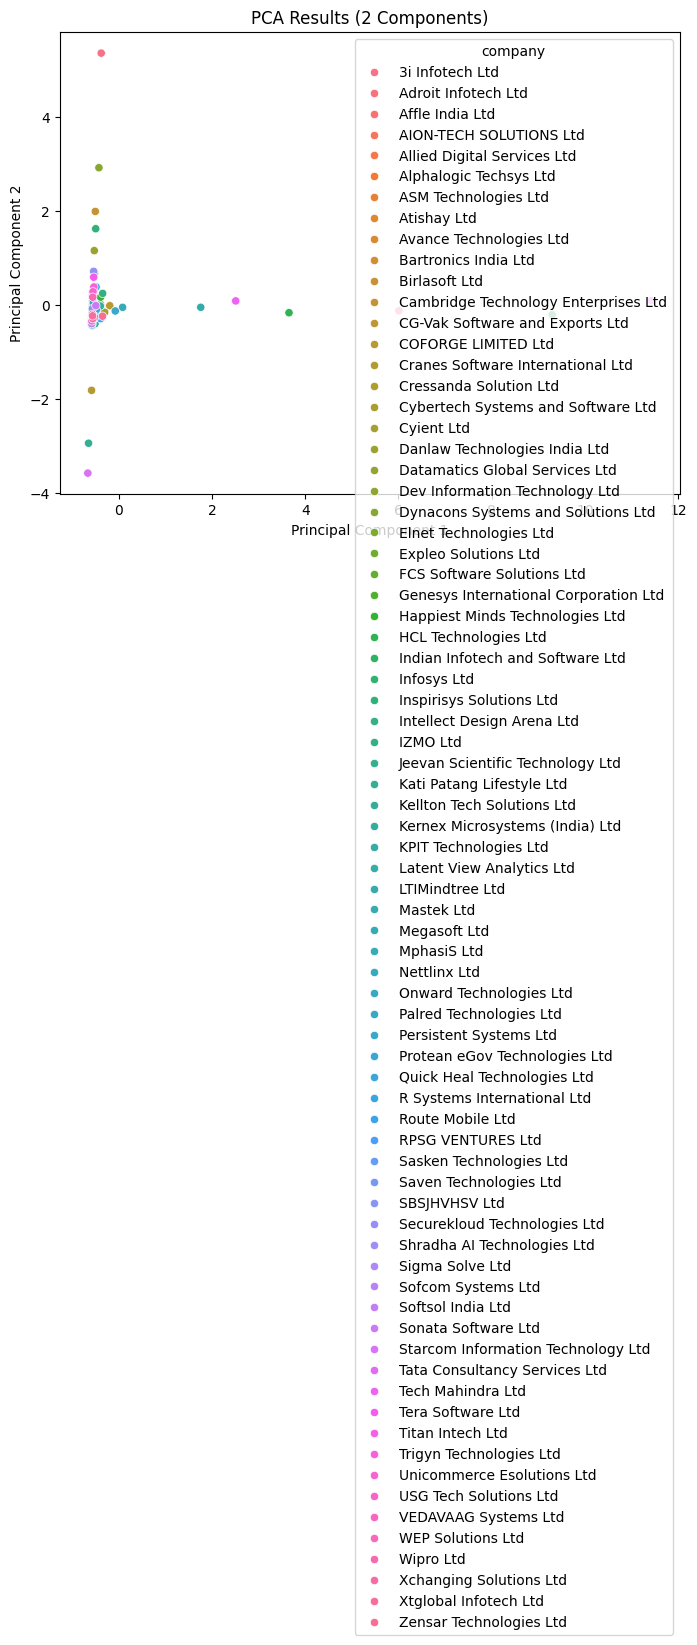

In [15]:
# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Print explained variance ratio
print("Explained variance ratio by PC1 and PC2:", pca.explained_variance_ratio_)

# Visualize the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue=df['company'])
plt.title("PCA Results (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()